In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [12]:
df = pd.read_csv("../../data/processed/ERA5_Full_Dataset.csv")
df.head()

,time,pressure_level,altitude,temperature,relative_humidity,specific_humidity,u,v,wind_speed,d2m,...,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100
0,1998-12-31 21:00:00,1,58373.873278,266.782809,0.000164,0.000004,-53.115034,-1.046399,53.125341,291.047976,...,101323.855318,0.000109,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092
1,1998-12-31 22:00:00,1,58377.070499,266.133571,0.000173,0.000004,-56.079982,4.207988,56.237634,291.102855,...,101362.271230,0.000055,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653
2,1998-12-31 23:00:00,1,58378.955239,266.425400,0.000167,0.000004,-59.579416,11.225047,60.627622,291.094585,...,101384.923973,0.000068,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661
3,1999-01-01 00:00:00,1,58377.803403,265.834933,0.000179,0.000004,-61.247199,15.127236,63.087659,290.857967,...,101371.079419,0.000055,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327
4,1999-01-01 01:00:00,1,58371.907529,264.006273,0.000209,0.000004,-63.268755,15.352730,65.104851,290.804592,...,101300.243267,0.000035,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807


### Equation CN2 index

$$
C_n^2(z) = \left(\frac{A P(z)}{\langle T \rangle^2(z)}\right)^2 \cdot \frac{E(fL,z)exp(-3(ln\frac{ft}{fL})-\frac{5}{3}(ln\frac{fl}{ft}))}{0.125} \cdot fl^{5/3}
$$

In [35]:
def calculate_psd(time_series, sampling_frequency=1):
    """ Calcular a densidade espectral de potência de uma série temporal. """
    frequencies, psd_values = welch(time_series, fs=sampling_frequency, nperseg=1024)
    return frequencies, psd_values


def identify_frequencies(psd_values, frequencies):
    """ Identificar f_L, f_l, f_t com base na análise da PSD. """
    # Este é um exemplo simplificado. Você deve adaptar este método para seu caso específico.
    f_L = frequencies[np.argmax(psd_values)]  # Exemplo: pico mais baixo de frequência
    f_l = frequencies[-1]  # Frequência mais alta disponível
    f_t = frequencies[len(frequencies) // 2]  # Frequência média
    return f_L, f_l, f_t

def calculate_E_fL(freqs, psd, fL):
    return np.trapz(psd[freqs <= fL], freqs[freqs <= fL])

def calculate_cn2(A, P, T, fL, fl, ft, E_fL):
    term1 = ((A*P)/(T**2))**2
    term2 = (E_fL*np.exp(-3*np.log(ft/fL)-5/3*np.log(fl/ft)))/(0.125)
    term3 = fl**(5/3)

    return term1*term2*term3

In [41]:
wind_freq_dict = {}
wind_psd_dict = {}
wind_fL_dict = {}
wind_ft_dict = {}
wind_fl_dict = {}
wind_E_fL_dict = {}
wind_cn2_dict = {}

for pressure_level in df['pressure_level'].unique():
    print(f"Calculating for pressure level {pressure_level} hPa")
    aux_df = df[df['pressure_level'] == pressure_level]
    aux_df['temperature'] = aux_df['temperature'] - 273.15
    variable_pressure_level = aux_df['wind_speed'].values

    # Calculating PSD and identifying f_L, f_l, f_t
    frequencies, psd_values = calculate_psd(variable_pressure_level)
    wind_freq_dict[pressure_level] = frequencies
    wind_psd_dict[pressure_level] = psd_values
    fL, fl, ft = identify_frequencies(psd_values, frequencies)
    wind_fL_dict[pressure_level] = fL
    wind_ft_dict[pressure_level] = ft
    wind_fl_dict[pressure_level] = fl
    wind_E_fL_dict[pressure_level] = calculate_E_fL(frequencies, psd_values, fL)
    # Parameter to calculate cn2
    A = (80*10**-6)/pressure_level
    P = pressure_level
    T = aux_df['temperature'].mean()
    wind_cn2_dict[pressure_level] = calculate_cn2(A, P, T, fL, fl, ft, wind_E_fL_dict[pressure_level])

Calculating for pressure level 1 hPa
Calculating for pressure level 100 hPa
Calculating for pressure level 200 hPa
Calculating for pressure level 300 hPa
Calculating for pressure level 400 hPa
Calculating for pressure level 500 hPa
Calculating for pressure level 600 hPa


/tmp/ipykernel_1211834/4015100254.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['temperature'] = aux_df['temperature'] - 273.15


Calculating for pressure level 700 hPa
Calculating for pressure level 800 hPa
Calculating for pressure level 900 hPa
Calculating for pressure level 1000 hPa


In [40]:
temp_freq_dict = {}
temp_psd_dict = {}
temp_fL_dict = {}
temp_ft_dict = {}
temp_fl_dict = {}   
temp_E_fL_dict = {}
temp_cn2_dict = {}

for pressure_level in df['pressure_level'].unique():
    print(f"Calculating for pressure level {pressure_level} hPa")
    aux_df = df[df['pressure_level'] == pressure_level].dropna()
    aux_df['temperature'] = aux_df['temperature'] - 273.15
    variable_pressure_level = aux_df['temperature'].values

    # Calculating PSD and identifying f_L, f_l, f_t
    frequencies, psd_values = calculate_psd(variable_pressure_level)
    temp_freq_dict[pressure_level] = frequencies
    temp_psd_dict[pressure_level] = psd_values
    fL, fl, ft = identify_frequencies(psd_values, frequencies)
    temp_fL_dict[pressure_level] = fL
    temp_ft_dict[pressure_level] = ft
    temp_fl_dict[pressure_level] = fl
    temp_E_fL_dict[pressure_level] = calculate_E_fL(frequencies, psd_values, fL)
    # Parameter to calculate cn2
    A = (80*10**-6)/pressure_level
    # A = (80*10**-6)/pressure_level
    # A = 10e-5
    P = pressure_level
    T = aux_df['temperature'].mean()
    temp_cn2_dict[pressure_level] = calculate_cn2(A, P, T, fL, fl, ft, temp_E_fL_dict[pressure_level])

Calculating for pressure level 1 hPa
Calculating for pressure level 100 hPa
Calculating for pressure level 200 hPa
Calculating for pressure level 300 hPa
Calculating for pressure level 400 hPa
Calculating for pressure level 500 hPa
Calculating for pressure level 600 hPa
Calculating for pressure level 700 hPa
Calculating for pressure level 800 hPa
Calculating for pressure level 900 hPa
Calculating for pressure level 1000 hPa


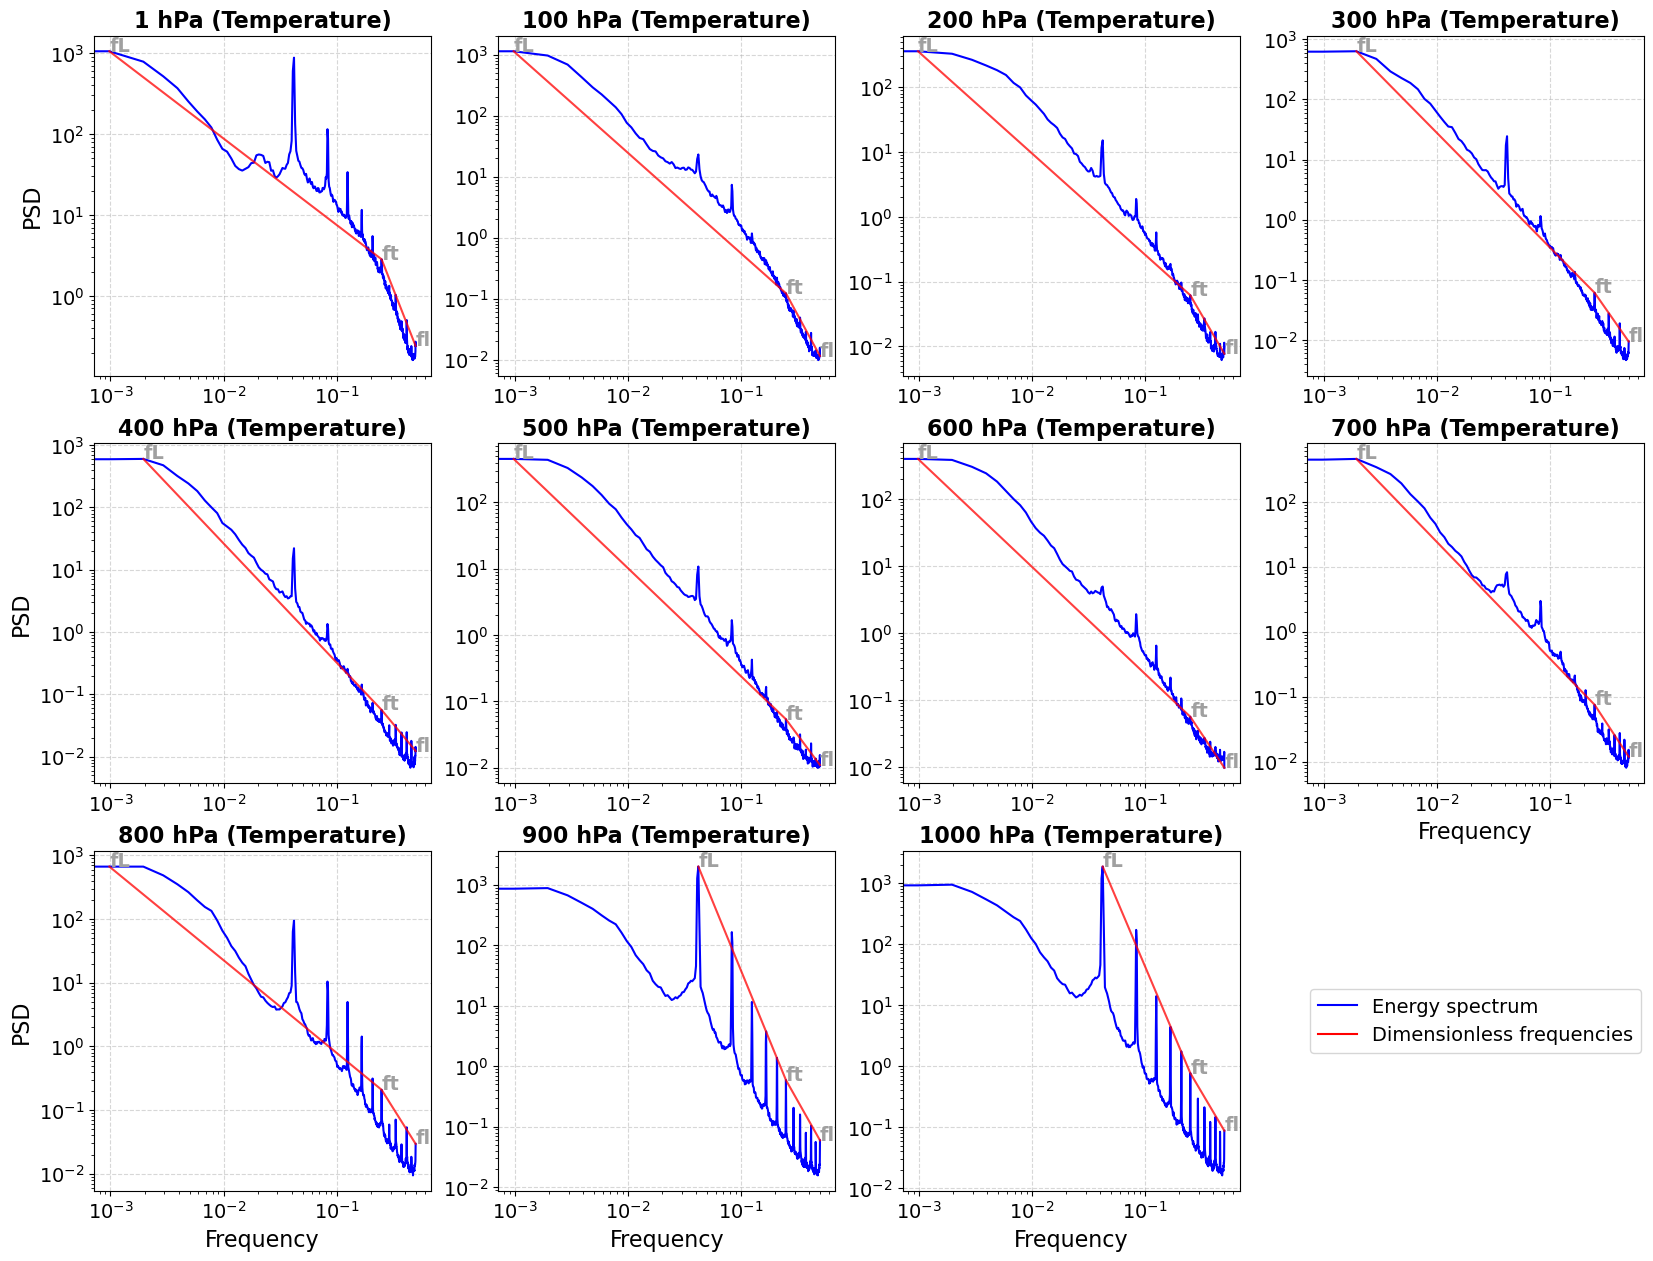

In [24]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, pressure_level in enumerate(df['pressure_level'].unique()):
    # print(f"Plotting for pressure level {pressure_level} hPa")
    row, col = i // 4, i % 4
    # print(row, col)
    # print()
    ax[row, col].set_title(f"{pressure_level} hPa (Temperature)", fontsize=16, fontweight='bold')
    ax[row, col].plot(temp_freq_dict[pressure_level], temp_psd_dict[pressure_level], label=f"PSD {pressure_level} hPa", color='blue')
    psd_values = temp_psd_dict[pressure_level]
    frequencies = temp_freq_dict[pressure_level]
    f_L_idx = np.argmax(psd_values)
    f_l_idx = -1
    f_t_idx = len(frequencies) // 2
    marker_values = [psd_values[f_L_idx], psd_values[f_t_idx], psd_values[f_l_idx]]
    marker_frequencies = [frequencies[f_L_idx], frequencies[f_t_idx], frequencies[f_l_idx]]

    # ax[row, col].scatter(marker_frequencies, marker_values, color='black', zorder=5)
    ax[row, col].plot(marker_frequencies, marker_values, color='red', zorder=5, alpha=0.75)
    ax[row, col].set_yscale('log')
    ax[row, col].set_xscale('log')

    # add label above each marker
    for j, txt in enumerate(['fL', 'ft', 'fl']):
        ax[row, col].text(marker_frequencies[j], marker_values[j], txt, color='#a0a0a0', fontsize=14, fontweight=800)
    ax[row, col].grid(ls='--', alpha=0.5)

    if col == 0:
        ax[row, col].set_ylabel('PSD', fontsize=16)
    if col == 3 and row == 1:
        ax[row, col].set_xlabel('Frequency', fontsize=16)
    if row == 2:
        ax[row, col].set_xlabel('Frequency', fontsize=16)

    # alter size of both ticks
    ax[row, col].tick_params(axis='both', which='major', labelsize=14)


ax[-1][-1].plot([], color='blue', label='Energy spectrum')
ax[-1][-1].plot([], color='red', label='Dimensionless frequencies')
ax[-1][-1].legend(loc='center', fontsize=14)
ax[-1][-1].axis('off')


plt.savefig("Frequencies_Parameters_Temperature_Based.png", dpi=72, pad_inches=0.1, bbox_inches='tight')
plt.savefig("Frequencies_Parameters_Temperature_Based.pdf", dpi=150, pad_inches=0.1, bbox_inches='tight')


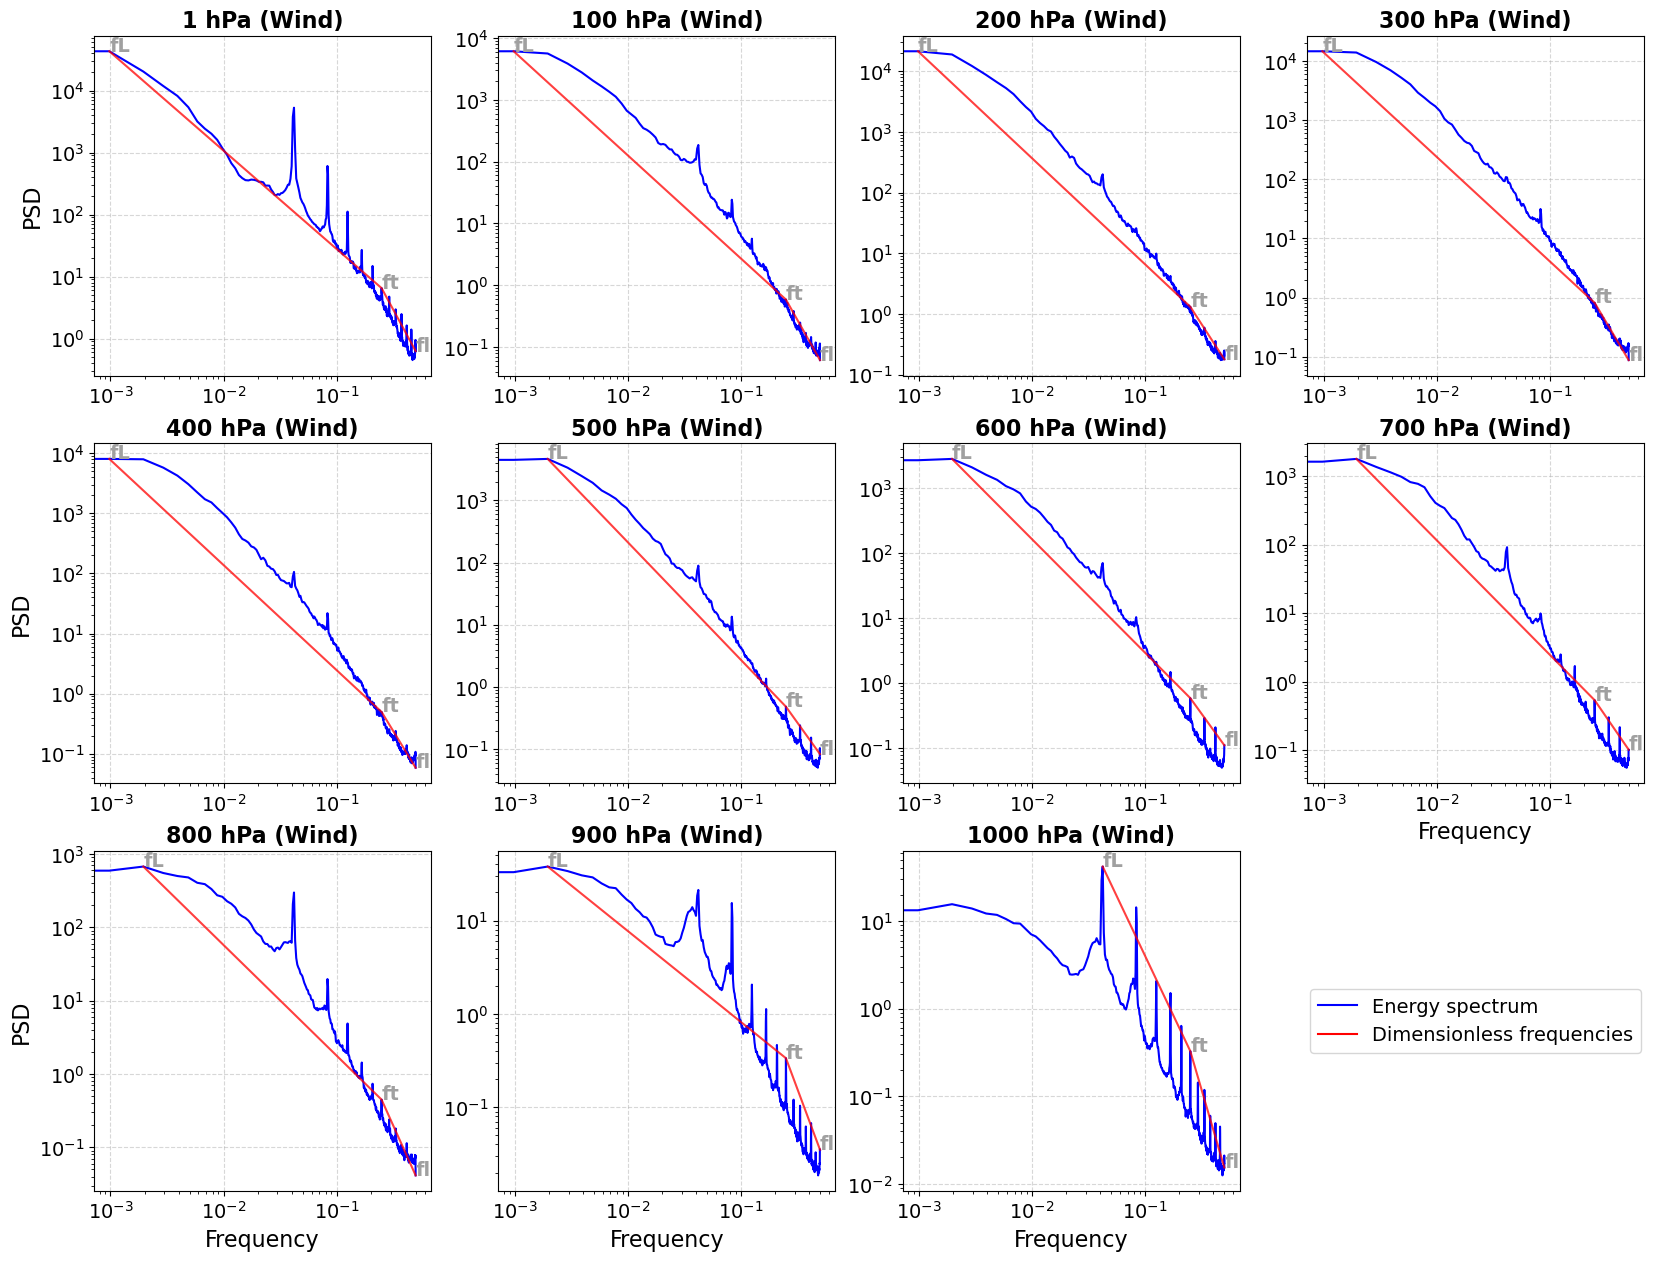

In [25]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i, pressure_level in enumerate(df['pressure_level'].unique()):
    # print(f"Plotting for pressure level {pressure_level} hPa")
    row, col = i // 4, i % 4
    # print(row, col)
    # print()
    ax[row, col].set_title(f"{pressure_level} hPa (Wind)", fontsize=16, fontweight='bold')
    ax[row, col].plot(wind_freq_dict[pressure_level], wind_psd_dict[pressure_level], label=f"PSD {pressure_level} hPa", color='blue')
    psd_values = wind_psd_dict[pressure_level]
    frequencies = wind_freq_dict[pressure_level]
    f_L_idx = np.argmax(psd_values)
    f_l_idx = -1
    f_t_idx = len(frequencies) // 2
    marker_values = [psd_values[f_L_idx], psd_values[f_t_idx], psd_values[f_l_idx]]
    marker_frequencies = [frequencies[f_L_idx], frequencies[f_t_idx], frequencies[f_l_idx]]

    # ax[row, col].scatter(marker_frequencies, marker_values, color='black', zorder=5)
    ax[row, col].plot(marker_frequencies, marker_values, color='red', zorder=5, alpha=0.75)
    ax[row, col].set_yscale('log')
    ax[row, col].set_xscale('log')

    # add label above each marker
    for j, txt in enumerate(['fL', 'ft', 'fl']):
        ax[row, col].text(marker_frequencies[j], marker_values[j], txt, color='#a0a0a0', fontsize=14, fontweight=800)
    ax[row, col].grid(ls='--', alpha=0.5)

    if col == 0:
        ax[row, col].set_ylabel('PSD', fontsize=16)
    if col == 3 and row == 1:
        ax[row, col].set_xlabel('Frequency', fontsize=16)
    if row == 2:
        ax[row, col].set_xlabel('Frequency', fontsize=16)

    # alter size of both ticks
    ax[row, col].tick_params(axis='both', which='major', labelsize=14)


ax[-1][-1].plot([], color='blue', label='Energy spectrum')
ax[-1][-1].plot([], color='red', label='Dimensionless frequencies')
ax[-1][-1].legend(loc='center', fontsize=14)
ax[-1][-1].axis('off')

plt.savefig("Frequencies_Parameters_Wind_Based.png", dpi=72, pad_inches=0.1, bbox_inches='tight')
plt.savefig("Frequencies_Parameters_Wind_Based.pdf", dpi=150, pad_inches=0.1, bbox_inches='tight')


In [42]:
heights = df.groupby('pressure_level').agg({'altitude': 'mean'}).to_dict()['altitude']

profile_cn2 = {
    'heights': list(heights.keys()),
    'altitudes': list(heights.values()),
    'wind_cn2': list(wind_cn2_dict.values()),
    'temp_cn2': list(temp_cn2_dict.values())
}

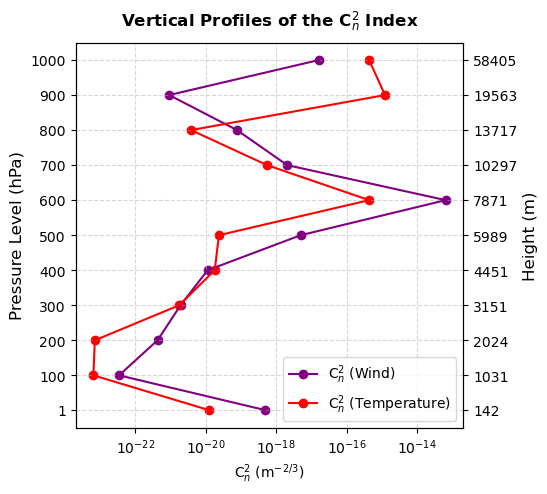

In [43]:
# Plotting cn2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_title(r"Vertical Profiles of the C$^{2}_{n}$ Index", fontweight='bold', y=1.02)
ax.plot(profile_cn2['wind_cn2'], profile_cn2['heights'], color='purple')
ax.scatter(profile_cn2['wind_cn2'], profile_cn2['heights'], color='purple')
ax.set_yticks(profile_cn2['heights'])
ax.plot([], 'o-', color='purple', label=r'C$^{2}_{n}$ (Wind)')

ax.plot(profile_cn2['temp_cn2'], profile_cn2['heights'], color='red')
ax.scatter(profile_cn2['temp_cn2'], profile_cn2['heights'], color='red')
ax.plot([], 'o-', color='red', label=r'C$^{2}_{n}$ (Temperature)')
ax.set_ylabel("Pressure Level (hPa)", fontsize=12)
ax.set_xlabel(r"C$^{2}_{n}$ (m$^{-2/3}$)")

# Create secondary y-axis
ax2 = ax.twinx()
ax2.plot(['']*len(profile_cn2['heights']), profile_cn2['heights'], color='black', alpha=0)

# New list of values for secondary y-axis tick labels (modify as needed)]
ax2.set_yticks(profile_cn2['heights'])
ax2.set_yticklabels([int(v) for v in profile_cn2['altitudes'][::-1]])
ax2.set_ylabel("Height (m)", fontsize=12)

ax.legend()
ax.grid(ls='--', alpha=0.5)
ax.set_xscale('log')

plt.savefig("Vertical_Profiles_cn2.png", dpi=72, pad_inches=0.1, bbox_inches='tight')
plt.savefig("Vertical_Profiles_cn2.pdf", dpi=150, pad_inches=0.1, bbox_inches='tight')